In [1]:
from my_utils.stardisting import load_model
from my_utils import tile_processing as tp

from stardist.matching import matching_dataset as scorer
import os
from tqdm import tqdm
import pandas as pd

In [2]:
base_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets"

In [3]:
model_name = 'Model 49'
model = load_model(model_path=os.path.join(os.path.join(base_folder, "StarDist Model Candidates"), model_name),
                   new_model_path_for_retraining=False,
                   from_last_weights=False)
model_name = 'SD_HE_20x'

base_model.py (149): output path for model already exists, files may be overwritten: \\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\StarDist Model Candidates\Model 49


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.694669, nms_thresh=0.3.
Overriding defaults: Thresholds(prob=0.694668575772041, nms=0.3) 


In [4]:
path_ints = os.path.join(base_folder, "Interpolations")
interpolations = os.listdir(path_ints)

In [5]:
taus = [0.5]
columns = ['Model', 'Interpolation', 'Dataset', 'Tile', 'Tau', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score', 'Panoptic Quality']
df_scores = pd.DataFrame(columns=columns)

In [6]:
def write_row(column_names, vals, df):
    row = pd.DataFrame(pd.Series(index=column_names)).T
    for c, col_name in enumerate(column_names):
        row[col_name] = vals[c]
    return pd.concat([df, row], ignore_index=True, axis=0)

In [7]:
for interpolation in tqdm(interpolations, desc='Interpolation'):
# for interpolation in [interpolations[0]]:
    path_datasets = os.path.join(path_ints, interpolation)
    for dataset in os.listdir(path_datasets):
    # for dataset in [os.listdir(path_datasets)[0]]:
        path_imgs = os.path.join(os.path.join(path_datasets, dataset), r'images')
        path_msks = os.path.join(os.path.join(path_datasets, dataset), r'masks')
        tile_sets = tp.TileSetReader([path_imgs, path_msks], ['.tif', '.tif']).tile_sets
        # [0]-basenames, [1][0]-images, [1][1]-gt, need to add [1][2]-pred
        tile_sets[1].append([])
        for i, img in enumerate(tile_sets[1][0]):
            img = img / 255
            pred, _ = model.predict_instances(img)
            tile_sets[1][2].append(pred)
            gt = tile_sets[1][1][i]
            gt, pred = tp.remove_margin_objects(gt, percent_margin=5), tp.remove_margin_objects(pred, percent_margin=5)
            for tau in taus:
            # for tau in [taus[0]]:
                scores = scorer([gt], [pred], thresh=tau, show_progress=False)._asdict()
                values = [model_name, interpolation, dataset, tile_sets[0][i], tau,
                          scores['tp'], scores['fp'], scores['fn'],
                          scores['precision'], scores['recall'], scores['f1'], scores['panoptic_quality']]
                df_scores = write_row(columns, values, df_scores)

Interpolation: 100%|██████████| 26/26 [12:23<00:00, 28.60s/it]


(-0.5, 1023.5, 1023.5, -0.5)

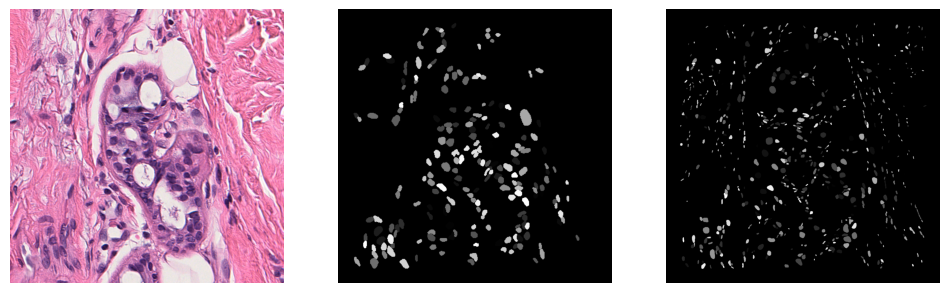

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust figsize as needed
axs[0].imshow(img, cmap='gray')
axs[0].axis('off')
axs[1].imshow(gt, cmap='gray')
axs[1].axis('off')
axs[2].imshow(pred, cmap='gray')
axs[2].axis('off')

In [9]:
df_scores

,Model,Interpolation,Dataset,Tile,Tau,TP,FP,FN,Precision,Recall,F1-Score,Panoptic Quality
0,SD_HE_20x,L - 20x - 0_,CoNSeP,test_1,0.5,407,145,288,0.737319,0.585612,0.652767,0.460056
1,SD_HE_20x,L - 20x - 0_,CoNSeP,test_10,0.5,482,112,158,0.811448,0.753125,0.781199,0.588921
2,SD_HE_20x,L - 20x - 0_,CoNSeP,test_11,0.5,280,155,586,0.643678,0.323326,0.430438,0.304569
3,SD_HE_20x,L - 20x - 0_,CoNSeP,test_12,0.5,210,80,110,0.724138,0.656250,0.688525,0.494448
4,SD_HE_20x,L - 20x - 0_,CoNSeP,test_13,0.5,725,176,435,0.804661,0.625000,0.703542,0.517540
...,...,...,...,...,...,...,...,...,...,...,...,...
2621,SD_HE_20x,R - 40x - 3_,JHU,Skin_train_1,0.5,68,355,138,0.160757,0.330097,0.216216,0.151858
2622,SD_HE_20x,R - 40x - 3_,JHU,Skin_train_2,0.5,5,404,45,0.012225,0.100000,0.021786,0.013047
2623,SD_HE_20x,R - 40x - 3_,JHU,Skin_train_3,0.5,393,447,275,0.467857,0.588323,0.521220,0.371294
2624,SD_HE_20x,R - 40x - 3_,JHU,Skin_train_4,0.5,132,293,200,0.310588,0.397590,0.348745,0.245194


In [10]:
out_folder = r"\\10.99.68.53\Digital pathology image lib\_Image libraries for training\2023-05-09 Published HE Nuclei Datasets\Segmentation Scores on Interpolations"
df_scores.to_csv(os.path.join(out_folder, 'SD_HE_20x.csv'), index=False)